# Third Assignment

##MSc course in Artificial Intelligence

insert your "Luca Pernigo"

In [1]:
# !rm -r AI_USI_MA/
# !git clone https://github.com/UmbertoJr/AI_USI_MA.git

name: eil76
nPoints: 76
best_sol: 538.0


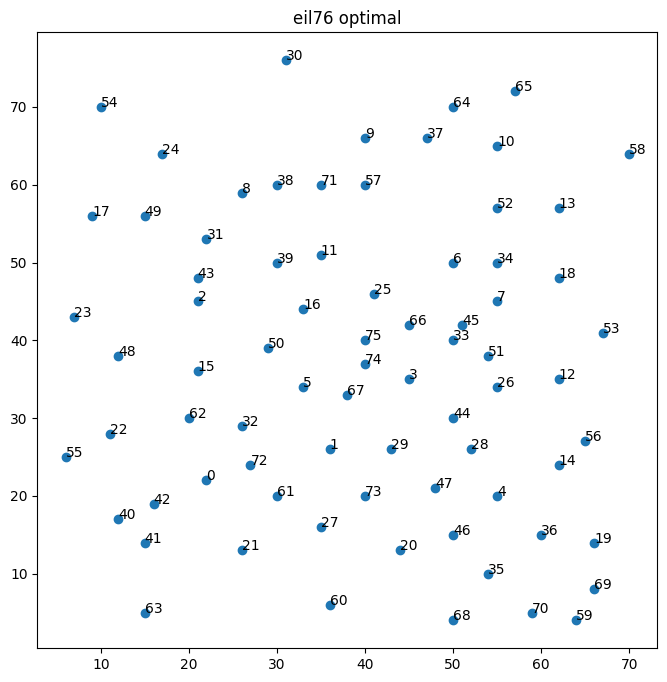

In [2]:
# Imports

from AI_USI_MA.IO_manager.io_tsp import TSP_Instance_Creator
from AI_USI_MA.solvers.constructive_algorithms import compute_length
from time import time
import matplotlib.pyplot as plt
from AI_USI_MA.solvers.two_opt_with_candidate import twoOpt_with_cl
import pandas as pd
import numpy as np
# if you are running from your local remove the prefix AI2020 (comment the previous line and uncomment the following line)
#from IO_manager.io_tsp import TSP_Instance_Creator

ic = TSP_Instance_Creator("standard", 'eil76.tsp')
ic.print_info()
ic.plot_data()

name: ch130
nPoints: 130
best_sol: 6110.0


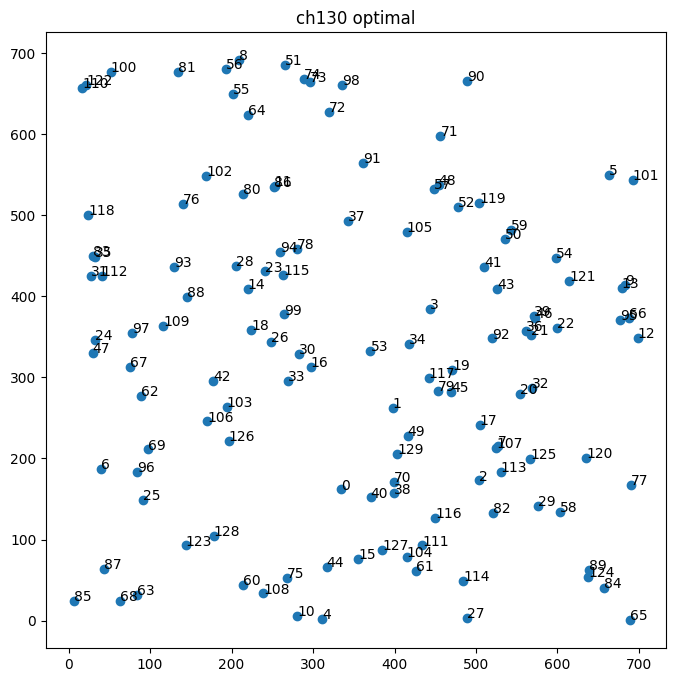

In [3]:
ic = TSP_Instance_Creator("standard", 'ch130.tsp')
ic.print_info()
ic.plot_data()

name: d198
nPoints: 198
best_sol: 15780.0


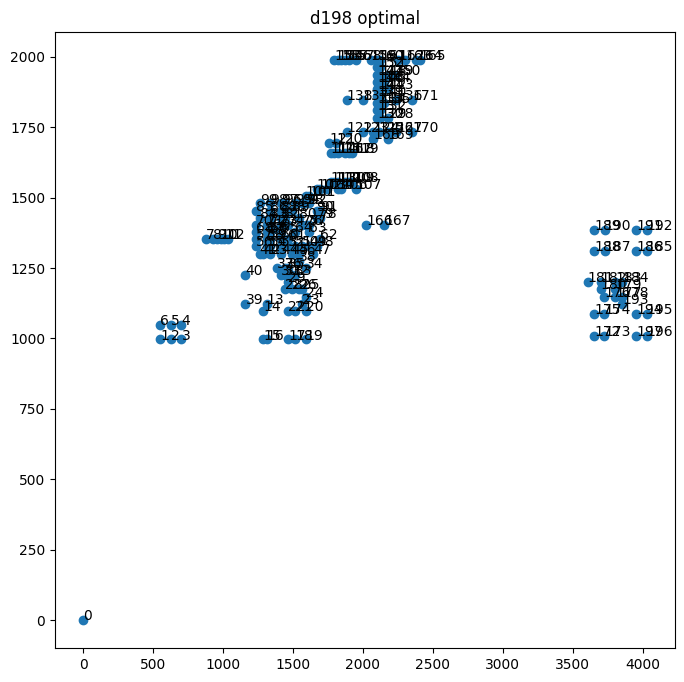

In [4]:
ic = TSP_Instance_Creator("standard", 'd198.tsp')
ic.print_info()
ic.plot_data()

name: myTSP_dim10
nPoints: 10
best_sol: 2732.0


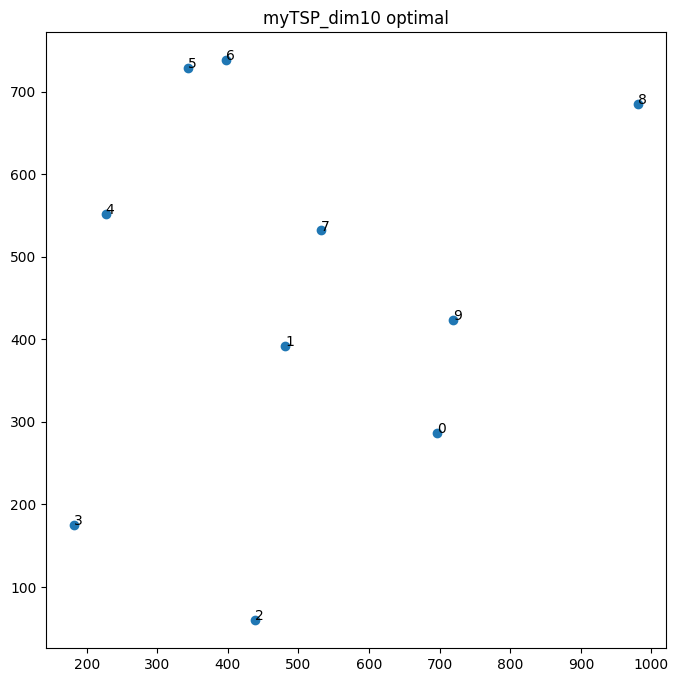

In [5]:
ic = TSP_Instance_Creator("standard", 'myTSP_dim10.tsp')
ic.print_info()
ic.plot_data()

In [6]:
# Function to read the pop music candidate list provided

def read_candidate_list_from_LKH(file_name):
    """
    This function reads the candidate list generated from the LKH implementation.

    Parameters:
    - file_name: the name of the file containing the candidate list, of type *.cl

    Returns:
    - candidate_list: a dictionary where the key is the node number, and the value is a list of candidate edges
    """
    candidate_list = {}
    
    try:
        with open(file_name, 'r') as file:
            num_nodes = int(file.readline().strip())
    
            for line in file:
                line_data = list(map(int, line.strip().split()))
    
                if line_data[0] == -1:
                    break
    
                node_number = line_data[0]
                num_candidate_edges = line_data[2]
    
                # Extract candidate edges information (end node number, alpha-value)
                # Since we do not care about the alpha values in this setting
                # I do not store them, everything else I kept as provided
                candidate_edges = [line_data[i] - 1 for i in range(3, 2 * num_candidate_edges + 3, 2)]
                candidate_list[node_number - 1] = candidate_edges

    except:
        print("NOTE: There is no cl file for this instance, popmusic will not work for this instance")
    return candidate_list


In [7]:
# read_candidate_list_from_LKH("AI_USI_MA/problems/TSP/CLs/ch130.cl")

In [8]:
import numpy as np
from AI_USI_MA.solvers.local_search import twoOpt
from AI_USI_MA.solvers.constructive_algorithms import nn

# nn takes as input the distance matrix and returns
# the tour and the length constructed with nearest neighbor, i.e.   tour, len_t = nn(dist_mat)

# twoOpt takes as input the solution, the actual_len and the distance matrix
# and returns the tour and the length created with 2-opt, i.e.     tour, lent_t = twoOpt(solution, actual_len, dist_mat)

class ACS:
  # number of ants
  m = 10
  # beta, importance of trail
  beta = 2
  # pheromone evaporation rate, rho
  alpha = rho = 0.1
  # candidate list size
  cl = 15

  

  @staticmethod
  # returns candidate nodes of j-th city
  def take_candidates(j, dist_mat):
    return list(np.argsort(dist_mat[j])[1:ACS.cl+1])

  def __init__(self, instance, q0):
    # q0 for state transition rule
    self.q0=q0 #0.98, 0,5 (1-13/self.n)

    # points of the problem
    self.n = instance.nPoints
    # distance matrix of the problem
    self.dist_mat = instance.dist_matrix
    # compute nn tour len of the passed instance distance matrix
    # starting from a random node
    _, self.L_nn = nn(instance.dist_matrix, starting_node=np.random.choice(self.n))
    
    # tau zero, initial pheromone level
    self.tau0 = 1./(float(self.n) * self.L_nn)
    
    # position collector for the Ants, TO BE UPDATED during the steps      
    self.position = {i: None for i in range(ACS.m)} 
 

    # I GUESS FOR EVERY STEP WE NEED TO ADD ELEMENT TO EACH i-th city
    # tour collector for the Ants
    self.tour = {i: [] for i in range(ACS.m)}  
    
    # pheromone for each node
    self.pheromone = {r: [self.tau0]*ACS.cl for r in range(self.n)}
    # ACS.cl
    
    # for each node take its 15 candidates
    self.candidate_list = {r: ACS.take_candidates(r, instance.dist_matrix) for r in range(self.n)}

    # eta η, inverse of distances for TSP
    self.eta = {r: [1/self.dist_mat[r, s] for s in ACS.take_candidates(r, instance.dist_matrix)] for r in range(self.n)}


    
    # pop music candidate list
    self.pop_music_cl=read_candidate_list_from_LKH(f"AI_USI_MA/problems/TSP/CLs/{instance.name}.cl")
      
    self.pheromone_all={r: [self.tau0]*(self.n) for r in range(self.n)}
    self.best_tour_ever=[]
    self.best_length_ever=np.inf
    self.best_k=0

    self.true_sol=ic.best_sol

    # dist matrix
    self.dist_matrix=instance.dist_matrix

    # number of tours
    self.num_tours=0

    # array to keep track of tours lens for each iteration
    self.it_lens=[]

    # list to track best lenght evolution
    self.ls_best_length=[]

  def initialize(self):
    # reset tour and position
    self.tour={i: [] for i in range(ACS.m)}  
    self.position={i: None for i in range(ACS.m)} 
    self.Jkr={i: np.arange(self.n) for i in range(ACS.m)}
      
    random_n=np.random.choice(self.n, ACS.m, replace=False)
    # print(random_n)
    for i in range(self.m):
        self.tour[i]+=[random_n[i]]
        self.position[i]=random_n[i]

        # definition of Jkr
        self.Jkr[i]=np.delete(self.Jkr[i], random_n[i])
    # print(self.tour)

  def get_pheromone(self, k):
    # neighbourhood Jk
    Jkr=self.Jkr[k]

    # position ant k
    rk=self.position[k]
    # print(np.array(self.pheromone_all[rk]))

      
    # get the list of all pheromones for rk and slice it by the nodes in its current feasible neighborhood
    pheromone=np.array(self.pheromone_all[rk])[[Jkr]][0]
    #  *np.arange(self.n)
    return pheromone
    
  # ant k
  def get_eta(self, k):
      # neighbourhood Jk
      Jkr=self.Jkr[k]

      # position ant k
      rk=self.position[k]
      eta=np.array([1/self.dist_mat[rk, s] for s in  Jkr])
      return eta
      
  def transition(self, k):
      
      pheromone_eta=(self.get_pheromone(k)*self.get_eta(k))**self.beta
      
      # position ant k
      rk=self.position[k]
      
      if np.random.uniform(0,1,1)<self.q0:
          # print("we transition best")!
          # best sk in Jkr
          sk=self.Jkr[k][np.argmax(pheromone_eta)]
 
          # np.delete(self.candidate_list[np.argmax(pheromone_eta)][rk], rk)
      else:
          # print("we transition randomly")!
          transition_probability=pheromone_eta
          # introduce bias we do not want to randomly end up in the best when we are in this else block
          # if we can choose between more than one element be remove the biased one
          # otherwise if we are left with only one choice we select it with probability one
          if len(transition_probability)>1:
              transition_probability[np.argmax(pheromone_eta)]=0
          
          transition_probability=transition_probability/np.sum(transition_probability)
          
          sk= np.random.choice(self.Jkr[k], p=transition_probability)

      return sk

    
  def local(self):
      
      sk={k: None for k in range(ACS.m)}  
      # for every city
      for i in range(self.n):
          # n-1 otherwise it overflows
          if i<self.n-1:
              
              # for every ant
              for k in range(self.m):
                  # print(i,k)
                  # rk is current position of k-th ant
                  rk=self.position[k]
                  # compute sk, i.e. the node to which ant k is supposed to transition
                  sk[k]=self.transition(k)
                  # print("Next node sk", sk[k])!
                  # print("Neigihbourhood rk", self.Jkr[k])!
                  # Jk(sk)=Jk(rk)-sk we create the neighborhood of sk
                  self.Jkr[k]=np.delete(self.Jkr[k], np.where(self.Jkr[k]== sk[k]) ).copy()
                  
                  self.tour[k]+=[sk[k]]
              
          else:
              
              for k in range(self.m):
                  sk[k]=self.tour[k][0]
                  self.tour[k]+=[self.tour[k][0]]

          # LOCAL UPDATE RULE

          for k in range(self.m):
              
              # print(i,k, self.candidate_list[self.position[k]], self.tour[k][-1])
              rk=self.position[k]
              # get pheromone rk and sk,
              # that is get the pheromone lsit for node rk and slice by pair sk
              # it works since pheromone list of each rk is an array with lenght=problem size
              # so slicing works as expected
              pheromone_rk_sk=self.pheromone_all[rk][sk[k]].copy()
              self.pheromone_all[rk][sk[k]]=(1-self.rho)*pheromone_rk_sk+self.rho*self.tau0
                                                 # )+1000
              
              
              self.position[k]=sk[k]
            


      
  def best(self):
      
      self.best_k=0
      ant_k_lens=[compute_length(self.tour[k][:-1], self.dist_mat) for k in range(self.m)]
      self.it_lens+=[ant_k_lens]
      # calculate new global best if any
      for k in range(self.m):
          # take all elements except the last
          # since last element of tour is the starting point
          # of the tour itself; this in order to align with
          # the compute_length input format
          if compute_length(self.tour[k][:-1], self.dist_mat)<=self.best_length_ever:
              self.best_tour_ever=self.tour[k][:-1]
              self.best_length_ever=compute_length(self.tour[k][:-1], self.dist_mat)
              self.best_k=k
      
    
      
      # print("New best lenght ever achieved:", self.best_length_ever)

  def best_twoopt(self):
      # find best ant in the iteration
      ant_k_lens=[compute_length(self.tour[k][:-1], self.dist_mat) for k in range(self.m)]
      self.it_lens+=[ant_k_lens]
      # ant k that minimizes tour len
      self.best_k=np.argmin(ant_k_lens)
      # best tour and len of current iteration
      iteration_best_tour=self.tour[self.best_k][:-1]
      iteration_best_len=ant_k_lens[self.best_k]
      
      # apply two opt
      iteration_best_tour, iteration_best_len=twoOpt(iteration_best_tour, iteration_best_len, acs.dist_matrix)
    
      # update global best
      # in the comparison i put misun equal in order
      # to mitigate the fact of getting stuck
      if iteration_best_len<=self.best_length_ever:
          self.best_length_ever=iteration_best_len
          self.best_tour_ever=iteration_best_tour

      
      # print("New best lenght ever achieved:", self.best_length_ever)

  def best_twoopt_cl(self):      

      # find best ant in the iteration
      ant_k_lens=[compute_length(self.tour[k][:-1], self.dist_mat) for k in range(self.m)]
      self.it_lens+=[ant_k_lens]
      # ant k that minimizes tour len
      self.best_k=np.argmin(ant_k_lens)
      # best tour and len of current iteration
      iteration_best_tour=self.tour[self.best_k][:-1]
      iteration_best_len=ant_k_lens[self.best_k]
      
      # apply two opt with vanilla candidate list
      iteration_best_tour, iteration_best_len=twoOpt_with_cl(iteration_best_tour, iteration_best_len, acs.dist_matrix, acs.candidate_list)
      # update global best
      if iteration_best_len<=self.best_length_ever:
          self.best_length_ever=iteration_best_len
          self.best_tour_ever=iteration_best_tour

      
      # print("New best lenght ever achieved:", self.best_length_ever)


  def best_twoopt_popmusic_cl(self):      
        
      # find best ant in the iteration
      ant_k_lens=[compute_length(self.tour[k][:-1], self.dist_mat) for k in range(self.m)]
      self.it_lens+=[ant_k_lens]
      # ant k that minimizes tour len
      self.best_k=np.argmin(ant_k_lens)
      # best tour and len of current iteration
      iteration_best_tour=self.tour[self.best_k][:-1]
      iteration_best_len=ant_k_lens[self.best_k]
      
      # apply two opt with vanilla candidate list
      iteration_best_tour, iteration_best_len=twoOpt_with_cl(iteration_best_tour, iteration_best_len, acs.dist_matrix, acs.pop_music_cl)
      # update global best
      if iteration_best_len<=self.best_length_ever:
          self.best_length_ever=iteration_best_len
          self.best_tour_ever=iteration_best_tour

      
      # print("New best lenght ever achieved:", self.best_length_ever)
        
  
  def globl(self):
      for i in range(0,len(self.best_tour_ever)-1):
          self.pheromone_all[self.best_tour_ever[i]][self.best_tour_ever[i+1]]=(1-self.alpha)*self.pheromone_all[self.best_tour_ever[i]][self.best_tour_ever[i+1]]+self.alpha*1/self.best_length_ever
        
          
  def solve(self, time_to_solve=5, two_opt=False, candidate_list=None):
      start = time()
      i=0
      
      if candidate_list=="popmusic" and self.pop_music_cl=={}:
          return 0
      
      # bool_convergence=False
      # while time has not expired
      # and while we have not converged yet
      # keep looping
      while (time()-start<time_to_solve) and self.best_length_ever-self.true_sol>0:
          # print("Iteration i", i)
          self.initialize()

          self.local()

          if two_opt==False:
              self.best()
              # ten new solutions explored
              self.num_tours+=self.m
      
          else:
              if candidate_list==None:
                  self.best_twoopt()
              elif candidate_list=="standard":
                  self.best_twoopt_cl()
              elif candidate_list=="popmusic":
                  self.best_twoopt_popmusic_cl()

              # ten new solutions explored plus the one generated by twoopt
              self.num_tours+=self.m+1
          
          self.ls_best_length+=[self.best_length_ever].copy()  
          
          self.globl() 
          i+=1


### Run the algorithm

In [160]:
ic = TSP_Instance_Creator("standard", 'eil76.tsp')
# myTSP_dim10
# eil76
# ch130
acs = ACS(ic, 0.5)
acs.solve(time_to_solve=5, two_opt=False, candidate_list=None)
res_q1=acs.ls_best_length

acs = ACS(ic, (1-13/ic.nPoints))
acs.solve(time_to_solve=5, two_opt=False, candidate_list=None)
res_q3=acs.ls_best_length

# q0= 0.98; 0.5; (1-13/ic.nPoints)

NOTE: There is no cl file for this instance, popmusic will not work for this instance
NOTE: There is no cl file for this instance, popmusic will not work for this instance


In [162]:
acs = ACS(ic, 0.98)
acs.solve(time_to_solve=5, two_opt=False, candidate_list=None)
acs.best_length_ever
# testing the implementation on the small tsp
# print the lenght evolution of global best tour
res_q2=acs.ls_best_length
acs.ls_best_length;

NOTE: There is no cl file for this instance, popmusic will not work for this instance


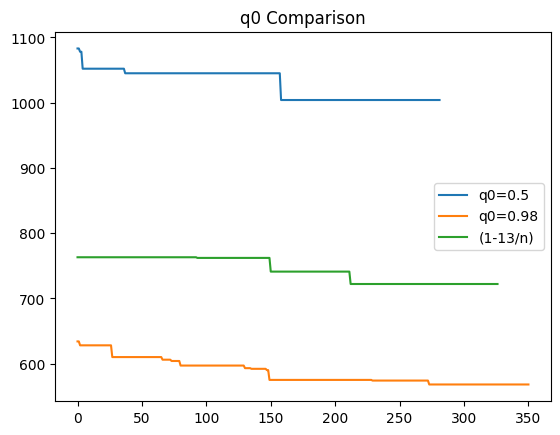

In [167]:
plt.plot(res_q1, label="q0=0.5")
plt.plot(res_q2, label="q0=0.98")
plt.plot(res_q3, label="(1-13/n)")
plt.title("q0 Comparison")
plt.legend();

### Set all combinations for the experiments

In [11]:
seeds = [4, 100, 4096]
instances=["eil76.tsp", "ch130.tsp", "d198.tsp"]
methods=["ACS", "ACS two_opt", "ACS two_opt candidate_list", "ACS two_opt popmusic"]
params=[[False, None], [True, None], [True, "standard"], [True, "popmusic"]]


### I did a couple of experiments and the best q0 between the three proposed in the assignment statement is 0.98. Thus, the following results have been obtained with setting q0=0.98

In [22]:
list_num_tours=[]
# list of best len ever achieved at the end of each combination
list_best_len=[]
list_gap=[]
# list of len for each 10 ants for each iteration of acs
list_it_lens=[]
# list of global best len evolutions
list_evo_best_len=[]

for instance in instances:
    for i,param in enumerate(params):
        for seed in seeds:
            ic = TSP_Instance_Creator("standard", instance)
            
            acs = ACS(ic, 0.98)
            print(f"Solving: {instance}, {methods[i]}, {seed}")
            # param[0] is wheter we use two opt or not
            # param[1] is the type of candidate list
            acs.solve(time_to_solve=180, two_opt=param[0], candidate_list=param[1])

            # store summary stats
            list_num_tours+=[acs.num_tours]
            list_best_len+=[acs.best_length_ever]
            list_gap+=[(acs.best_length_ever-ic.best_sol)/ic.best_sol]
            list_it_lens+=[acs.it_lens]
            list_evo_best_len+=[acs.ls_best_length]
            

NOTE: There is no cl file for this instance, popmusic will not work for this instance
Solving: eil76.tsp, ACS, 4
NOTE: There is no cl file for this instance, popmusic will not work for this instance
Solving: eil76.tsp, ACS, 100
NOTE: There is no cl file for this instance, popmusic will not work for this instance
Solving: eil76.tsp, ACS, 4096
NOTE: There is no cl file for this instance, popmusic will not work for this instance
Solving: eil76.tsp, ACS two_opt, 4
NOTE: There is no cl file for this instance, popmusic will not work for this instance
Solving: eil76.tsp, ACS two_opt, 100
NOTE: There is no cl file for this instance, popmusic will not work for this instance
Solving: eil76.tsp, ACS two_opt, 4096
NOTE: There is no cl file for this instance, popmusic will not work for this instance
Solving: eil76.tsp, ACS two_opt candidate_list, 4
NOTE: There is no cl file for this instance, popmusic will not work for this instance
Solving: eil76.tsp, ACS two_opt candidate_list, 100
NOTE: There is

In [23]:
# create dataframe of data
df=pd.DataFrame(list(zip(np.array([[methods[i]]*3 for i in range(len(methods))]*3).flatten()
    ,np.array([[instances[i]]*12 for i in range(len(instances))]).flatten(),
                      seeds*12,
                     list_num_tours,
                     list_best_len,
                      # multiply by 100 so to have gap in percentage units
                     np.array(list_gap)*100)),
               columns =["Method", 'Instance', 'Seed', "# Tours Generated",
                        "Best Cost", "Best Gap%"])
df

Method   Instance  Seed  # Tours Generated  Best Cost  \
0                          ACS  eil76.tsp     4             128000      554.0   
1                          ACS  eil76.tsp   100             128830      547.0   
2                          ACS  eil76.tsp  4096             129320      559.0   
3                  ACS two_opt  eil76.tsp     4              51414      538.0   
4                  ACS two_opt  eil76.tsp   100             119130      539.0   
5                  ACS two_opt  eil76.tsp  4096              45155      538.0   
6   ACS two_opt candidate_list  eil76.tsp     4              89199      548.0   
7   ACS two_opt candidate_list  eil76.tsp   100              89045      549.0   
8   ACS two_opt candidate_list  eil76.tsp  4096              89309      539.0   
9         ACS two_opt popmusic  eil76.tsp     4                  0        inf   
10        ACS two_opt popmusic  eil76.tsp   100                  0        inf   
11        ACS two_opt popmusic  eil76.tsp  4096                  0        inf   
12                         ACS  ch130.tsp     4              56450     6554.0   
13                         ACS  ch130.tsp   100              55870     6435.0   
14                         ACS  ch130.tsp  4096              55760     6371.0   
15                 ACS two_opt  ch130.tsp     4              29271     6110.0   
16                 ACS two_opt  ch130.tsp   100              35959     6155.0   
17                 ACS two_opt  ch130.tsp  4096              38181     6128.0   
18  ACS two_opt candidate_list  ch130.tsp     4              32659     6170.0   
19  ACS two_opt candidate_list  ch130.tsp   100              33616     6184.0   
20  ACS two_opt candidate_list  ch130.tsp  4096              32087     6177.0   
21        ACS two_opt popmusic  ch130.tsp     4              48026     6340.0   
22        ACS two_opt popmusic  ch130.tsp   100              47047     6255.0   
23        ACS two_opt popmusic  ch130.tsp  4096              47773     6247.0   
24                         ACS   d198.tsp     4              27840    17623.0   
25                         ACS   d198.tsp   100              27830    17446.0   
26                         ACS   d198.tsp  4096              27560    17244.0   
27                 ACS two_opt   d198.tsp     4               9207    15850.0   
28                 ACS two_opt   d198.tsp   100               9526    15834.0   
29                 ACS two_opt   d198.tsp  4096               9042    15867.0   
30  ACS two_opt candidate_list   d198.tsp     4              15609    15986.0   
31  ACS two_opt candidate_list   d198.tsp   100              14344    16174.0   
32  ACS two_opt candidate_list   d198.tsp  4096              16159    15920.0   
33        ACS two_opt popmusic   d198.tsp     4              23067    16235.0   
34        ACS two_opt popmusic   d198.tsp   100              22682    16238.0   
35        ACS two_opt popmusic   d198.tsp  4096              22737    15989.0   

    Best Gap%  
0    2.973978  
1    1.672862  
2    3.903346  
3    0.000000  
4    0.185874  
5    0.000000  
6    1.858736  
7    2.044610  
8    0.185874  
9         inf  
10        inf  
11        inf  
12   7.266776  
13   5.319149  
14   4.271686  
15   0.000000  
16   0.736498  
17   0.294599  
18   0.981997  
19   1.211129  
20   1.096563  
21   3.764321  
22   2.373159  
23   2.242226  
24  11.679341  
25  10.557668  
26   9.277567  
27   0.443599  
28   0.342205  
29   0.551331  
30   1.305450  
31   2.496831  
32   0.887199  
33   2.883397  
34   2.902408  
35   1.324461

In [105]:
# df=pd.read_csv("acs.csv", index_col=0)

In [104]:
# print(df.to_latex())

### Averaged across seeds

In [28]:
df[["Instance", "Method", "# Tours Generated", "Best Cost",
   "Best Gap%"]].groupby(["Instance", "Method"]).mean()
# pd.read_csv('avg_acs_seed')

Instance                      Method  # Tours Generated     Best Cost  \
0   ch130.tsp                         ACS       56026.666667  6.453333e+03   
1   ch130.tsp                 ACS two_opt       34470.333333  6.131000e+03   
2   ch130.tsp  ACS two_opt candidate_list       32787.333333  6.177000e+03   
3   ch130.tsp        ACS two_opt popmusic       47615.333333  6.280667e+03   
4    d198.tsp                         ACS       27743.333333  1.743767e+04   
5    d198.tsp                 ACS two_opt        9258.333333  1.585033e+04   
6    d198.tsp  ACS two_opt candidate_list       15370.666667  1.602667e+04   
7    d198.tsp        ACS two_opt popmusic       22828.666667  1.615400e+04   
8   eil76.tsp                         ACS      128716.666667  5.533333e+02   
9   eil76.tsp                 ACS two_opt       71899.666667  5.383333e+02   
10  eil76.tsp  ACS two_opt candidate_list       89184.333333  5.453333e+02   
11  eil76.tsp        ACS two_opt popmusic           0.000000           inf   

    Best Gap%  
0    5.619203  
1    0.343699  
2    1.096563  
3    2.793235  
4   10.504858  
5    0.445712  
6    1.563160  
7    2.370089  
8    2.850062  
9    0.061958  
10   1.363073  
11        inf

### Plotting

In [103]:
# pd.read_csv("df_evo_best_len.csv", index_col=0)

In [88]:
df_evo_best_len=pd.DataFrame(list(zip(np.array([[instances[i]]*12 for i in range(len(instances))]).flatten(),
    np.array([[methods[i]]*3 for i in range(len(methods))]*3).flatten(),
    
                      seeds*12,
                 list_evo_best_len
                 )),
               columns =["Instance", 'Method', 'Seed', "List evo best len"])

In [154]:
# across all instance, method pairs store the maximum number of iterations obtained with different seeds
max_len=[max(map(len, list_evo_best_len[i:i+3])) for i in range(0, len(list_evo_best_len), 3)]
max_len=np.array([[max_len[i]]*3 for i in range(len(max_len))]).flatten()

In [227]:
# pad the arrays so that now have same lenght for different seeds and so we can average on the seeds the evolution
# of the methods
padded=[list + [list[-1]] * (max - len(list)) if len(list) > 0 else list for list, max in zip(list_evo_best_len, max_len)]

In [270]:
avg_evo_best_len=[np.mean(padded[j:j+3], axis=0) for j in np.arange(0,36,3)]

In [303]:
df_avg_best_len=pd.DataFrame(list(zip(np.array([[instances[i]]*4 for i in range(len(instances))]).flatten(),
    np.array([[methods[i]]*1 for i in range(len(methods))]*3).flatten(),
    
                      
                 avg_evo_best_len
                 )),
               columns =["Instance", 'Method',  "Avg evo best len"])

In [32]:
df_avg_best_len

Instance                      Method  \
0   eil76.tsp                         ACS   
1   eil76.tsp                 ACS two_opt   
2   eil76.tsp  ACS two_opt candidate_list   
3   eil76.tsp        ACS two_opt popmusic   
4   ch130.tsp                         ACS   
5   ch130.tsp                 ACS two_opt   
6   ch130.tsp  ACS two_opt candidate_list   
7   ch130.tsp        ACS two_opt popmusic   
8    d198.tsp                         ACS   
9    d198.tsp                 ACS two_opt   
10   d198.tsp  ACS two_opt candidate_list   
11   d198.tsp        ACS two_opt popmusic   

                                     Avg evo best len  
0   [645.33333333 645.         635.66666667 ... 55...  
1   [569.         566.66666667 566.66666667 ... 53...  
2   [587.66666667 577.33333333 570.66666667 ... 54...  
3                                                [0.]  
4   [7461.66666667 7461.66666667 7454.33333333 ......  
5   [6492.33333333 6470.33333333 6470.33333333 ......  
6   [6983.33333333 6941.         6742.66666667 ......  
7   [7135.66666667 7030.33333333 6964.         ......  
8   [18772.33333333 18772.33333333 18767.66666667 ...  
9   [16451.66666667 16451.66666667 16451.66666667 ...  
10  [17701.33333333 17565.         17565.         ...  
11  [18247.66666667 18247.66666667 18057.66666667 ...

In [102]:
# pd.read_csv("df_avg_best_len.csv", index_col=0)

In [42]:
def plot_avg(df_avg_best_len, instance):
    df_instance=df_avg_best_len[df_avg_best_len["Instance"]==instance]

    for i in df_instance.index:
        
        y=df_instance.loc[i]["Avg evo best len"]
        if len(y)==1:
            break
        
        plt.plot(df_instance.loc[i]["Avg evo best len"], label=df_instance.loc[i]["Method"])
    plt.legend()
    plt.title(f"ACS Algorithms Comparison for {instance}")

In [168]:
# plot for the Gap
def plot_avg2(df_avg_best_len, instance):
    df_instance=df_avg_best_len[df_avg_best_len["Instance"]==instance]
    ic=TSP_Instance_Creator("standard", f"{instance}")
    for i in df_instance.index:
        
        y=df_instance.loc[i]["Avg evo best len"]
        y=(y-ic.best_sol)/y
        
        if len(y)==1:
            break
        
        plt.plot(y, label=df_instance.loc[i]["Method"])
    plt.legend()
    plt.xlabel("# Iteration")
    plt.ylabel("Best Gap")
    plt.title(f"ACS Algorithms Gap Comparison for {instance}")

### Eil76

In [ ]:
plot_avg(df_avg_best_len, "eil76.tsp")

In [169]:
plot_avg2(df_avg_best_len, "eil76.tsp")

### Ch130

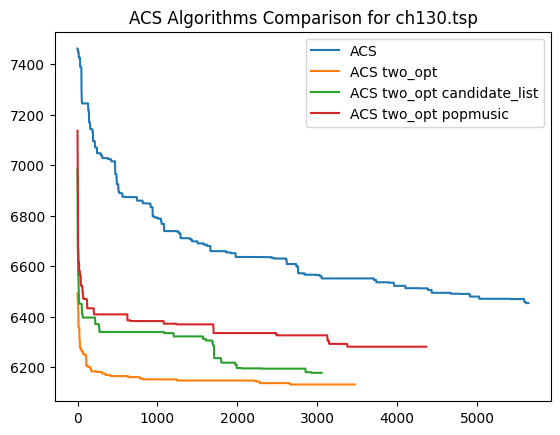

In [432]:
plot_avg(df_avg_best_len, "ch130.tsp")

In [170]:
plot_avg2(df_avg_best_len, "ch130.tsp")

### D198

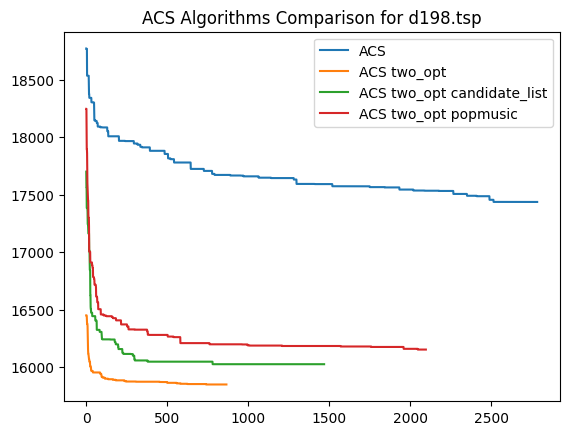

In [433]:
plot_avg(df_avg_best_len, "d198.tsp")

In [171]:
plot_avg2(df_avg_best_len, "d198.tsp")

### Drill down on ACS variant

In [434]:
def table_IV(df, method):
    df_ACS=df[df["Method"]==method]
    df_ACS=df_ACS.drop(columns="Seed")
    df_ACS
    
    # get the best rows across runs with different seeds, 
    # I keep only best row for each instance method pair across the different seeds
    min_cost_rows = df_ACS.groupby('Instance')['Best Cost'].idxmin()
    result_ACS = df_ACS.loc[min_cost_rows]
    
    # compute avg and sd
    result_ACS['Average Cost'] = df_ACS.groupby('Instance')['Best Cost'].mean().values
    result_ACS['Standard Deviation'] = df_ACS.groupby('Instance')['Best Cost'].std().values
    
    # the optimal solutions of the considered problems
    result_ACS["Optimum"]=[6110, 15780, 538]
    
    # display in the same format of table IV paper Ant Colony System: A Cooperative Learning
    # Approach to the Traveling Salesman Problem
    return result_ACS[["Instance", "Best Cost", "# Tours Generated", "Average Cost", "Standard Deviation", "Optimum","Best Gap%"]]

In [435]:
table_IV(df, "ACS")

Instance  Best Cost  # Tours Generated  Average Cost  Standard Deviation  \
14  ch130.tsp     6371.0              55760   6453.333333           92.867289   
26   d198.tsp    17244.0              27560  17437.666667          189.637373   
1   eil76.tsp      547.0             128830    553.333333            6.027714   

    Optimum  Best Gap%  
14     6110   4.271686  
26    15780   9.277567  
1       538   1.672862

In [108]:
# print(pd.read_csv("acs_table.csv", index_col=0).to_latex())

In [437]:
table_IV(df, "ACS two_opt")

Instance  Best Cost  # Tours Generated  Average Cost  Standard Deviation  \
15  ch130.tsp     6110.0              29271   6131.000000           22.649503   
28   d198.tsp    15834.0               9526  15850.333333           16.502525   
3   eil76.tsp      538.0              51414    538.333333            0.577350   

    Optimum  Best Gap%  
15     6110   0.000000  
28    15780   0.342205  
3       538   0.000000

In [113]:
# pd.read_csv("acs_twoopt_table.csv", index_col=0)

In [439]:
table_IV(df, "ACS two_opt candidate_list")

Instance  Best Cost  # Tours Generated  Average Cost  Standard Deviation  \
18  ch130.tsp     6170.0              32659   6177.000000            7.000000   
32   d198.tsp    15920.0              16159  16026.666667          131.792767   
8   eil76.tsp      539.0              89309    545.333333            5.507571   

    Optimum  Best Gap%  
18     6110   0.981997  
32    15780   0.887199  
8       538   0.185874

In [115]:
# pd.read_csv("acs_twoopt_cl_table.csv", index_col=0)

In [441]:
table_IV(df, "ACS two_opt popmusic")

Instance  Best Cost  # Tours Generated  Average Cost  Standard Deviation  \
23  ch130.tsp     6247.0              47773  6.280667e+03           51.539629   
35   d198.tsp    15989.0              22737  1.615400e+04          142.902064   
9   eil76.tsp        inf                  0           inf                 NaN   

    Optimum  Best Gap%  
23     6110   2.242226  
35    15780   1.324461  
9       538        inf

In [117]:
# pd.read_csv("acs_popmusic_table.csv", index_col=0)

### 

### Visualizing solution found

In [443]:
def plot_optimal_solution(self, solution_tour):
    # assert self.name in ["eil76", "kroA100"], f"the solution is not available for {self.name}"
    solution_tour=np.append(solution_tour, solution_tour[0])
    print(ic.name)

    plt.figure(figsize=(8, 8))
    plt.title(self.name)
    plt.scatter(self.points[:, 1], self.points[:, 2])
    for i, txt in enumerate(np.arange(self.nPoints)):  # tour_found[:-1]
        plt.annotate(txt, (self.points[i, 1], self.points[i, 2]))

    for i, j in zip(solution_tour[:-1], solution_tour[1:]):
        plt.plot([self.points[i, 1], self.points[j, 1]],
                 [self.points[i, 2], self.points[j, 2]], 'b-')
    
    plt.show()

d198


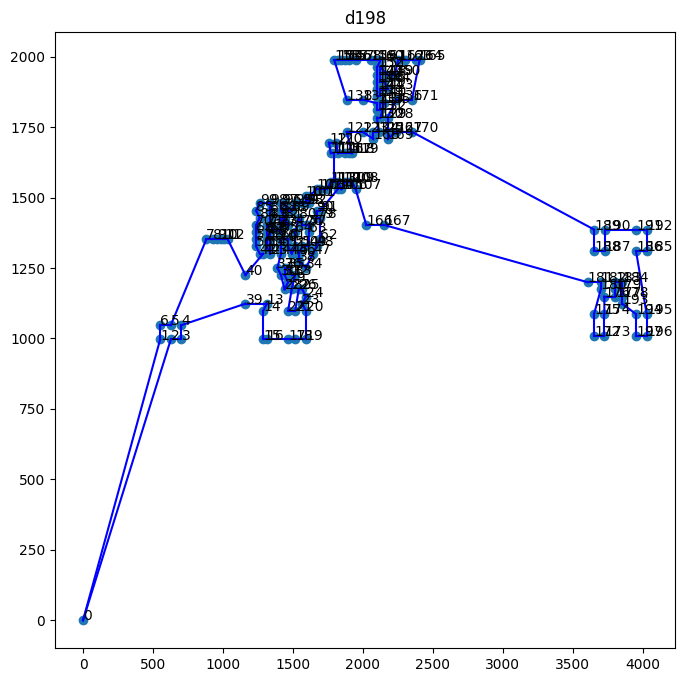

In [444]:
# best solution found by ACS
plot_optimal_solution(ic, acs.best_tour_ever)

In [49]:
# Test for initialize
# acs.initialize()
# print("Initialized tour:", acs.tour)
# print("Initialized position:", acs.position)
# print("Jkr:", acs.Jkr)

In [50]:
# Test get_eta
# print("Get eta function:", acs.get_eta(0))
# print("Eta directly from inverse of distance matrix:", 1/acs.dist_mat[acs.position[0],])
# # we get same results so it works as expected

In [51]:
# Test get_pheromone
# acs.get_pheromone(0)
# to carry out test insert in the return of get_pheromone *np.arange(self.n)
# in order to see that it slices the correct values

In [57]:
# Test transition()
# acs.transition(0)
# seems to work

In [52]:
# Test local()
# acs.initialize()
# acs.local()

In [53]:
# Test local
# sample tour
# acs.tour[0]

In [54]:
# Test local
# all edges are considered
# np.arange(acs.n)==sorted(acs.tour[1][0:-1])

In [55]:
# Test pheromone update by local rule

# see that the values thay are updated are the ones which the ant has followed
# to see that it updates correct values modify update rule just for testing purposes
# by putting a very large number
# acs.pheromone_all[9]

In [530]:
# Comparing vanilla candidate list and pop music candidate list

# acs.candidate_list
# acs.pop_music_cl

In [59]:
# np.delete(np.array([100,233,24,242]), np.where(np.array([100,233,24,242]) == 233))


### Following sections were already provided in the pynotebook file

In [1107]:
acs = ACS(ic)

# print tau zero
print('tau0 =', acs.tau0)

# for first four cities-->r print informations
for j in acs.candidate_list.keys():
  print()
  print("node          :", j)
  # print first three nodes -->s of candidate list
  print("candidate list:", acs.candidate_list[j][:3])
  # print first three eta values η(r,s)
  print("eta values    :", acs.eta[j][:3])
  # print first three pheromone values τ(r,s)
  print("pheromone     :", acs.pheromone[j][:3])
  # just for the first four cities
  if j>2:
    break


tau0 = 1.92648532018186e-05

node          : 0
candidate list: [72, 42, 32]
eta values    : [0.2, 0.14285714285714285, 0.125]
pheromone     : [1.92648532018186e-05, 1.92648532018186e-05, 1.92648532018186e-05]

node          : 1
candidate list: [73, 67, 29]
eta values    : [0.14285714285714285, 0.14285714285714285, 0.14285714285714285]
pheromone     : [1.92648532018186e-05, 1.92648532018186e-05, 1.92648532018186e-05]

node          : 2
candidate list: [43, 31, 15]
eta values    : [0.3333333333333333, 0.125, 0.1111111111111111]
pheromone     : [1.92648532018186e-05, 1.92648532018186e-05, 1.92648532018186e-05]

node          : 3
candidate list: [74, 75, 33]
eta values    : [0.2, 0.14285714285714285, 0.14285714285714285]
pheromone     : [1.92648532018186e-05, 1.92648532018186e-05, 1.92648532018186e-05]


# test twoOpt_with_cl

the implementation of 2opt with the candidate list has worst performances in term of quality but achieves improvements using fewer computation

In [315]:
from time import time
from AI_USI_MA.solvers.two_opt_with_candidate import twoOpt_with_cl

# ic is instance creator
ic = TSP_Instance_Creator("standard", 'eil76.tsp')
# 'fl1577.tsp'

# compute nearest neighbor
initial_sol, initial_len = nn(ic.dist_matrix, starting_node=np.random.choice(ic.nPoints))
acs = ACS(ic)

In [316]:
len(initial_sol)

76

In [263]:
twoOpt_with_cl(acs.best_tour_ever, acs.best_length_ever, ic.dist_matrix, acs.candidate_list)


(array([56, 14,  4, 36, 19, 69, 59, 70, 35, 68, 60, 21, 63, 41, 40, 42,  0,
        72, 61, 27, 73, 20, 46, 47, 29,  1, 67, 74, 75,  5, 50, 16, 39, 31,
        43,  2, 15, 32, 62, 22, 55, 48, 23, 17, 49, 54, 24,  8, 38, 71, 30,
        64, 65, 10, 37,  9, 57, 11, 25, 66, 33, 45,  7, 34,  6, 52, 13, 58,
        18, 53, 12, 26, 51,  3, 44, 28]),
 578.0)

In [261]:
acs.best_tour_ever

array([56, 14,  4, 36, 19, 69, 59, 70, 35, 68, 60, 21, 63, 41, 40, 42,  0,
       72, 61, 27, 73, 20, 46, 47, 29,  1, 67, 74, 75,  5, 50, 16, 39, 31,
       43,  2, 15, 32, 62, 22, 55, 48, 23, 17, 49, 54, 24,  8, 38, 71, 30,
       64, 65, 10, 37,  9, 57, 11, 25, 66, 33, 45,  7, 34,  6, 52, 13, 58,
       18, 53, 12, 26, 51,  3, 44, 28])

In [260]:
twoOpt(acs.best_tour_ever, acs.best_length_ever, ic.dist_matrix)

(array([ 3, 44, 28, 56, 14,  4, 36, 19, 69, 59, 70, 35, 68, 60, 21, 63, 41,
        40, 42,  0, 72, 61, 27, 73, 20, 46, 47, 29,  1, 67, 74, 75,  5, 50,
        16, 39, 31, 43,  2, 15, 32, 62, 22, 55, 48, 23, 17, 49, 54, 24,  8,
        38, 71, 30, 64, 65, 10, 37,  9, 57, 11, 25, 66, 33, 45,  7, 34,  6,
        52, 13, 58, 18, 53, 12, 26, 51]),
 578.0)

In [159]:
acs.best_length_ever

inf

In [894]:
start = time()
# applies 2-opt with candidate list
# takes as input initial sol, initial len, distance matrix of the problem
# and the candidate list
tour, len_new = twoOpt_with_cl(initial_sol, initial_len, ic.dist_matrix, acs.candidate_list)
print(f' 2opt with candidate: initial len {initial_len}, final len {len_new} \n execution time: {time() - start}')

start = time()
# 2-opt method
tour, len_new = twoOpt(initial_sol, initial_len, ic.dist_matrix)
print(f' 2opt: initial len {initial_len}, final len {len_new} \n execution time: {time() - start}')

 2opt with candidate: initial len 17815.0, final len 17542.0 
 execution time: 0.11336994171142578
 2opt: initial len 17815.0, final len 16994.0 
 execution time: 0.11488986015319824


### Code snippet that was already provided that compares timings of 2-opt_cl with 2-opt

In [147]:


list_time = []
for _ in range(5):
  initial_sol, initial_len = nn(ic.dist_matrix, starting_node=np.random.choice(ic.nPoints))
  start = time()
  _ = twoOpt_with_cl(initial_sol, initial_len, ic.dist_matrix, acs.candidate_list)
  list_time.append(time()- start)

print(f"mean {np.mean(list_time)},  std {np.std(list_time)}" )

mean 0.08941416740417481,  std 0.03003745021181732


In [148]:

list_time = []
for _ in range(5):
  initial_sol, initial_len = nn(ic.dist_matrix, starting_node=np.random.choice(ic.nPoints))
  start = time()
  _ = twoOpt(initial_sol, initial_len, ic.dist_matrix)
  list_time.append(time() - start)

print(f"mean {np.mean(list_time)},  std {np.std(list_time)}" )

mean 0.27161579132080077,  std 0.06872561510085944
